In [1]:
# Import PySpark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "10g") \
    .appName('Exam') \
    .getOrCreate() 
from pyspark.sql.functions import *

In [2]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
  width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
  width:max-content;
}
</style>

In [3]:
%%time
df =  spark.read.parquet('/Users/karla/Documents/Docs/Credit Cards Transactions/tablas_juntasf.parquet')

CPU times: total: 0 ns
Wall time: 2.35 s


In [4]:
df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show()

+------+----------+-------------+---------+----------+------+-------+---------+----+-----+-------+--------+---------+-----------------------+-------------------+---------+---------+--------------+---+---------+---------+--------+----------+-------+---+-------+-----------+-----------+------------+------------------+-------------+----+----+----+-----+---+----+------+--------+-------------+-------------+--------------+-------+---+--------+--------+
|Person|CurrentAge|RetirementAge|BirthYear|BirthMonth|Gender|Address|Apartment|City|State|Zipcode|Latitude|Longitude|PerCapitaIncome-Zipcode|YearlyIncome-Person|TotalDebt|FICOScore|NumCreditCards| id|CARDINDEX|CardBrand|CardType|CardNumber|Expires|CVV|HasChip|CardsIssued|CreditLimit|AcctOpenDate|YearPINlastChanged|CardonDarkWeb|User|Card|Year|Month|Day|Time|Amount|Use_Chip|Merchant_Name|Merchant_City|Merchant_State|    Zip|MCC|  Errors|Is_Fraud|
+------+----------+-------------+---------+----------+------+-------+---------+----+-----+-------+--

In [4]:
df = df.drop('MCC','Errors', 'Apartment')

# Limpieza e Ingeniería

In [5]:
us_states = ["AK","AL", "AR",
             "AZ","CA","CO",
             "CT", "DC","DE",
             "FL","GA","HI",
             "IA","ID","IL",
             "IN", "KS","KY",
             "LA","MA","MD",
             "ME","MI","MN",
             "MO","MS","MT",
             "NC","ND","NE",
             "NH","NJ","NM",
             "NV","NY","OH",
             "OK","OR","PA",
             "RI","SC","SD",
             "TN","TX","UT",
             "VA","VT","WA",
             "WI","WV","WY"]

In [6]:
from pyspark.sql.types import FloatType, DecimalType
df = df.select('Person',
                 'CurrentAge',
                 'RetirementAge',
                 'BirthYear',
                 'BirthMonth',
                 'Gender',
                 'Address',
                 'City',
                 'State',
                 'Zipcode',
                 'Latitude',
                 'Longitude',
                  regexp_replace(col("PerCapitaIncome-Zipcode"),
                                 "[^\d.]", "").cast(FloatType()).alias("PerCapitaIncome_Zipcode"),
                  regexp_replace(col("YearlyIncome-Person"),
                                 "[^\d.]", "").cast(FloatType()).alias("YearlyIncome_Person"),
                  regexp_replace(col("TotalDebt"),
                                 "[^\d.]", "").cast(FloatType()).alias("TotalDebt"),
                 'FICOScore',
                 'NumCreditCards',
                 'id',
                 'CARDINDEX',
                 'CardBrand',
                 'CardType',
                 'CardNumber',
                 'Expires',
                 'CVV',
                 'HasChip',
                 'CardsIssued',
                  regexp_replace(col("CreditLimit"), "[^\d.]", "").cast(FloatType()).alias("CreditLimit"),
                 'AcctOpenDate',
                 'YearPINlastChanged',
                 'CardonDarkWeb',
                 'User',
                 'Card',
                 'Year',
                 'Month',
                 'Day',
                 'Time',
                  regexp_replace(col("Amount"), "[^\d.]", "").cast(FloatType()).alias("Amount"),
                 'Use_Chip',
                 'Merchant_Name',
                 'Merchant_City',
                 when(col("Merchant_State").isNull(),
                      "ONLINE").otherwise(col("Merchant_State")).alias("Merchant_State"),
                 when(col("Zip").isNull(), "ONLINE").otherwise(col("Zip")).alias("Zip"),
                 'Is_Fraud')

In [7]:
df = df.select("*",
               when(col("Merchant_State").isin(us_states),
                    "US").when(col("Merchant_State").isin("ONLINE"),
                               "ONLINE").otherwise("ABROAD").alias("TransType"))

In [8]:
df = df.select("*",
               when(col("TransType") == 'US', col("Amount")).otherwise(0).alias('USAmount'),
               when(col("TransType") == 'ONLINE', col("Amount")).otherwise(0).alias('OnlineAmount'),
               when(col("TransType") == 'ABROAD', col("Amount")).otherwise(0).alias('AbroadAmount'),
               (2020-col("Year")).alias("Recency"),
               when((col("RetirementAge")-col("CurrentAge")) < 0, 0
                   ).otherwise((col("RetirementAge")-col("CurrentAge"))).alias("RemainingYears")
              )

In [9]:
# Quitamos los clientes que no tienen crédito.
df = df.filter((col("CreditLimit") > 0) & (col("CardType") == 'Credit'))

In [10]:
df.show(5)

+------------+----------+-------------+---------+----------+------+---------------+----------+-----+-------+--------+---------+-----------------------+-------------------+---------+---------+--------------+---+---------+---------+--------+---------------+-------+---+-------+-----------+-----------+------------+------------------+-------------+----+----+----+-----+---+-----+------+------------------+--------------------+-------------+--------------+------+--------+---------+--------+------------+------------+-------+--------------+
|      Person|CurrentAge|RetirementAge|BirthYear|BirthMonth|Gender|        Address|      City|State|Zipcode|Latitude|Longitude|PerCapitaIncome_Zipcode|YearlyIncome_Person|TotalDebt|FICOScore|NumCreditCards| id|CARDINDEX|CardBrand|CardType|     CardNumber|Expires|CVV|HasChip|CardsIssued|CreditLimit|AcctOpenDate|YearPINlastChanged|CardonDarkWeb|User|Card|Year|Month|Day| Time|Amount|          Use_Chip|       Merchant_Name|Merchant_City|Merchant_State|   Zip|Is_F

# TAD

In [11]:
f = df.groupBy(['Person', 'CurrentAge','FICOScore', 'RetirementAge',
                'YearlyIncome_Person', 'TotalDebt', 'NumCreditCards'])\
      .agg((sum("Amount").cast(DecimalType(10,2))).alias("TotalAmount"),
           (avg("Amount").cast(DecimalType(10,2))).alias("AvgAmount"),
           (max("Amount").cast(DecimalType(10,2))).alias("MaxAmount"),
           (min("Amount").cast(DecimalType(10,2))).alias("MinAmount"),
           count("id").alias("TotalTransactions"),
           count(when(col('TransType') == 'US', True)).alias('USTrans'),
           count(when(col('TransType') == 'ONLINE', True)).alias('OnlineTrans'),
           count(when(col('TransType') == 'ABROAD', True)).alias('AbroadTrans'),
           (avg("USAmount").cast(DecimalType(10,2))).alias("AvgUSAmount"),
           (avg("OnlineAmount").cast(DecimalType(10,2))).alias("AvgOnlineAmount"),
           (avg("AbroadAmount").cast(DecimalType(10,2))).alias("AvgAbroadAmount"),
           (max("CreditLimit").cast(DecimalType(10,2))).alias("MaxCreditLimit"),
           (min("CreditLimit").cast(DecimalType(10,2))).alias("MinCreditLimit"),
           (avg("CreditLimit").cast(DecimalType(10,2))).alias("AvgCreditLimit"),
           (max("Recency")).alias("Antiquity"),
           (max("RemainingYears")).alias("RemainingYears")
          )

In [12]:
f.show()

+------------------+----------+---------+-------------+-------------------+---------+--------------+-----------+---------+---------+---------+-----------------+-------+-----------+-----------+-----------+---------------+---------------+--------------+--------------+--------------+---------+--------------+
|            Person|CurrentAge|FICOScore|RetirementAge|YearlyIncome_Person|TotalDebt|NumCreditCards|TotalAmount|AvgAmount|MaxAmount|MinAmount|TotalTransactions|USTrans|OnlineTrans|AbroadTrans|AvgUSAmount|AvgOnlineAmount|AvgAbroadAmount|MaxCreditLimit|MinCreditLimit|AvgCreditLimit|Antiquity|RemainingYears|
+------------------+----------+---------+-------------+-------------------+---------+--------------+-----------+---------+---------+---------+-----------------+-------+-----------+-----------+-----------+---------------+---------------+--------------+--------------+--------------+---------+--------------+
|      Kaleb Miller|        59|      636|           66|            55571.0|  93

In [13]:
f.count()

1301

# Clientes repetidos

In [14]:
f.groupBy("Person").count().orderBy(col("count").desc()).show()

+----------------+-----+
|          Person|count|
+----------------+-----+
|Magdalena Farhad|    2|
|  Hazel Robinson|    2|
|  Lochlan Morris|    2|
| Casey El-Mafouk|    2|
|   Cassidy Anwar|    2|
|     Simeon Cruz|    1|
|  Jennifer Peres|    1|
|    Abril Martin|    1|
|  Cristian Adams|    1|
|   Dakota Rivera|    1|
|  Harrison Green|    1|
|  Gemma Masvidal|    1|
|       Ava Evans|    1|
|    Alia Stewart|    1|
|     Cali Brooks|    1|
| Markus Masvidal|    1|
|   Ingrid Thomas|    1|
|   Anabelle Cook|    1|
|  Zechariah Cook|    1|
|Danielle Stewart|    1|
+----------------+-----+
only showing top 20 rows



In [15]:
f.filter(col("Person") == "Magdalena Farhad").show()

+----------------+----------+---------+-------------+-------------------+---------+--------------+-----------+---------+---------+---------+-----------------+-------+-----------+-----------+-----------+---------------+---------------+--------------+--------------+--------------+---------+--------------+
|          Person|CurrentAge|FICOScore|RetirementAge|YearlyIncome_Person|TotalDebt|NumCreditCards|TotalAmount|AvgAmount|MaxAmount|MinAmount|TotalTransactions|USTrans|OnlineTrans|AbroadTrans|AvgUSAmount|AvgOnlineAmount|AvgAbroadAmount|MaxCreditLimit|MinCreditLimit|AvgCreditLimit|Antiquity|RemainingYears|
+----------------+----------+---------+-------------+-------------------+---------+--------------+-----------+---------+---------+---------+-----------------+-------+-----------+-----------+-----------+---------------+---------------+--------------+--------------+--------------+---------+--------------+
|Magdalena Farhad|        45|      663|           61|            38872.0|  94970.0|  

Notemos que tenemos diferente edad y zipcode, por lo tanto nos quedaremos con la edad más actual.

In [16]:
f = f.orderBy(col('CurrentAge').desc()).coalesce(1).dropDuplicates(subset = ['Person'])

In [17]:
f.count()

1296

# Guardamos

In [18]:
f.write.option("header", True).format("csv").save("/Users/karla/Documents/Docs/Credit Cards Transactions/Exam_TAD.csv")

# Python

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_p =  pd.read_csv('../data/TAD.csv')

In [3]:
df_p

,Person,CurrentAge,FICOScore,RetirementAge,YearlyIncome_Person,TotalDebt,NumCreditCards,TotalAmount,AvgAmount,MaxAmount,...,OnlineTrans,AbroadTrans,AvgUSAmount,AvgOnlineAmount,AvgAbroadAmount,MaxCreditLimit,MinCreditLimit,AvgCreditLimit,Antiquity,RemainingYears
0,Aaden Campbell,33,763,69,59613.0,36199.0,4,629403.44,74.22,1128.47,...,710,146,63.25,9.28,1.69,17600.0,17600.0,17600.00,14.0,36.0
1,Aaliyah Martin,43,704,74,45360.0,14587.0,3,581856.99,40.01,937.15,...,5288,54,30.59,9.08,0.34,12800.0,10900.0,11793.04,18.0,31.0
2,Aarav Farhad,48,673,64,27447.0,80850.0,5,284571.90,41.46,534.84,...,475,0,36.42,5.04,0.00,7800.0,7400.0,7513.65,15.0,16.0
3,Abby Wood,54,716,72,76431.0,115362.0,5,190148.65,68.74,1624.15,...,123,93,58.66,8.70,1.39,19300.0,19300.0,19300.00,11.0,18.0
4,Abigail Morales,19,782,63,55854.0,111042.0,1,4488.90,61.49,352.14,...,2,0,58.39,3.10,0.00,14600.0,14600.0,14600.00,0.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,Zoie Ward,64,605,62,39206.0,9219.0,4,487324.33,55.75,950.88,...,742,35,47.51,7.59,0.65,9700.0,4000.0,5569.60,17.0,0.0
1292,Zuri Xi,46,728,66,44768.0,59862.0,3,79595.51,72.03,874.99,...,64,10,65.21,5.74,1.09,9700.0,9700.0,9700.00,11.0,20.0
1293,Zyaire Baker,76,758,69,38800.0,25867.0,7,814186.63,109.21,3605.24,...,377,81,95.32,11.66,2.23,25600.0,25600.0,25600.00,17.0,0.0
1294,Zyaire Bennett,65,688,67,645.0,790.0,3,56251.66,44.89,480.00,...,128,0,38.73,6.16,0.00,100.0,100.0,100.00,10.0,2.0


# Análisis exploratorio

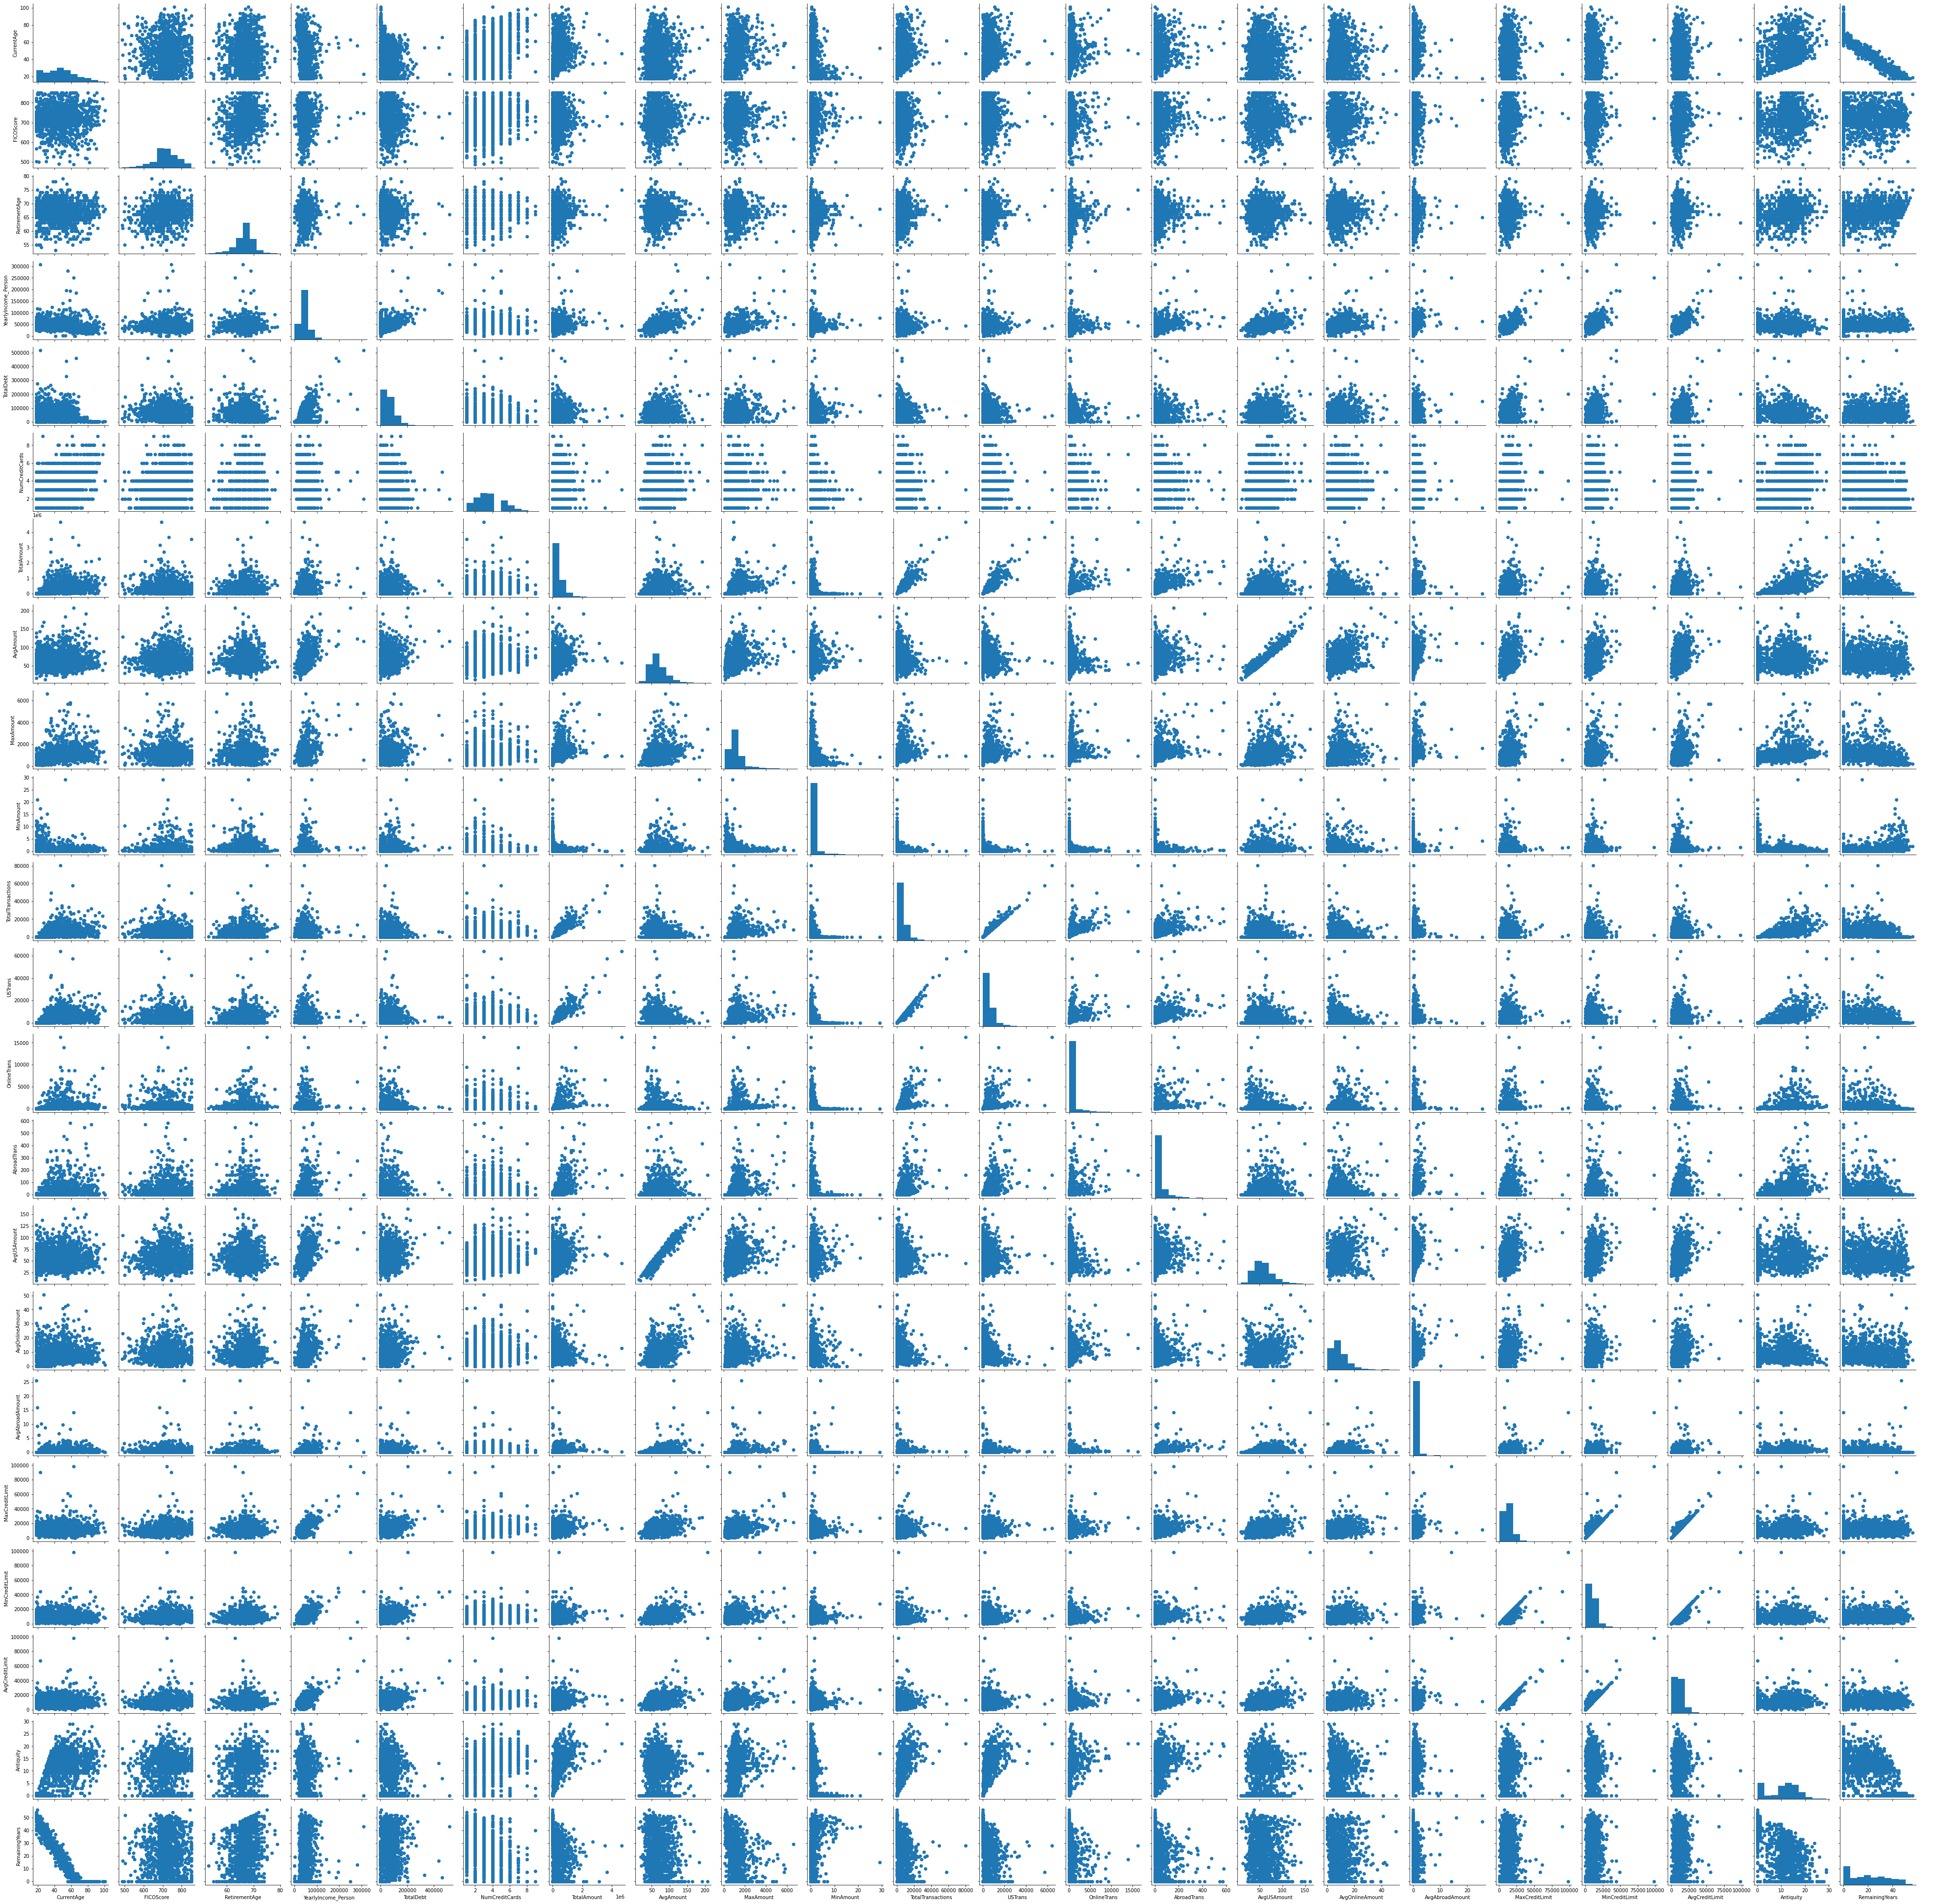

In [22]:
g = sns.PairGrid(df_p)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

# Modelación no sueprvisada

In [5]:
X = df_p[['CurrentAge', 'FICOScore', 'RetirementAge',
       'YearlyIncome_Person', 'TotalDebt', 'NumCreditCards', 'TotalAmount',
       'AvgAmount', 'MaxAmount', 'MinAmount', 'TotalTransactions', 'USTrans',
       'OnlineTrans', 'AbroadTrans', 'AvgUSAmount', 'AvgOnlineAmount',
       'AvgAbroadAmount', 'MaxCreditLimit', 'MinCreditLimit', 'AvgCreditLimit',
       'Antiquity', 'RemainingYears']]

In [6]:
# Primer paso 1: Estandarización
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
Xsc = pd.DataFrame(sc.transform(X), columns=X.columns)

# Paso 2: PCA
from sklearn.decomposition import PCA
k_components = 11
pca = PCA(k_components)
pca.fit(Xsc)
Xp = pd.DataFrame(pca.transform(Xsc), columns=[f'p{i}' for i in range(k_components)])

In [7]:
Xp

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
0,1.937901,0.800019,1.006367,1.000163,-1.030399,-0.115945,0.967579,0.588936,0.614776,-0.449140,0.760366
1,1.022020,-2.212934,2.546811,1.475901,-0.614103,2.553512,0.101446,-1.191951,0.965257,-0.212731,-0.165931
2,-1.292919,-1.715110,-0.022342,0.166127,0.994030,-0.284926,-0.460214,-0.170025,-0.348887,0.783975,0.777679
3,1.715967,1.795146,-0.395318,1.572795,0.375523,-0.231792,0.882725,-1.011776,0.307433,1.212958,0.086542
4,-2.328247,2.878876,1.643871,0.468807,0.207187,-0.829559,-0.621108,1.447038,-0.367737,-0.212042,-0.533214
...,...,...,...,...,...,...,...,...,...,...,...
1291,-0.041263,-2.488924,-0.871490,-1.351897,1.472946,-0.149504,-0.352522,-0.085915,0.680092,-0.087506,0.614091
1292,-1.060643,0.535870,-0.760064,-0.139996,0.018378,-0.536396,0.503489,0.108358,-0.062301,-0.056992,-0.340778
1293,5.225288,0.980927,-2.830824,1.114916,-0.402617,-0.537917,0.234537,-0.095467,0.458476,-0.438247,0.274950
1294,-3.211251,-2.651607,-1.616907,-0.462366,0.254864,0.285874,0.297620,-0.254979,0.595121,-0.014881,-0.624832


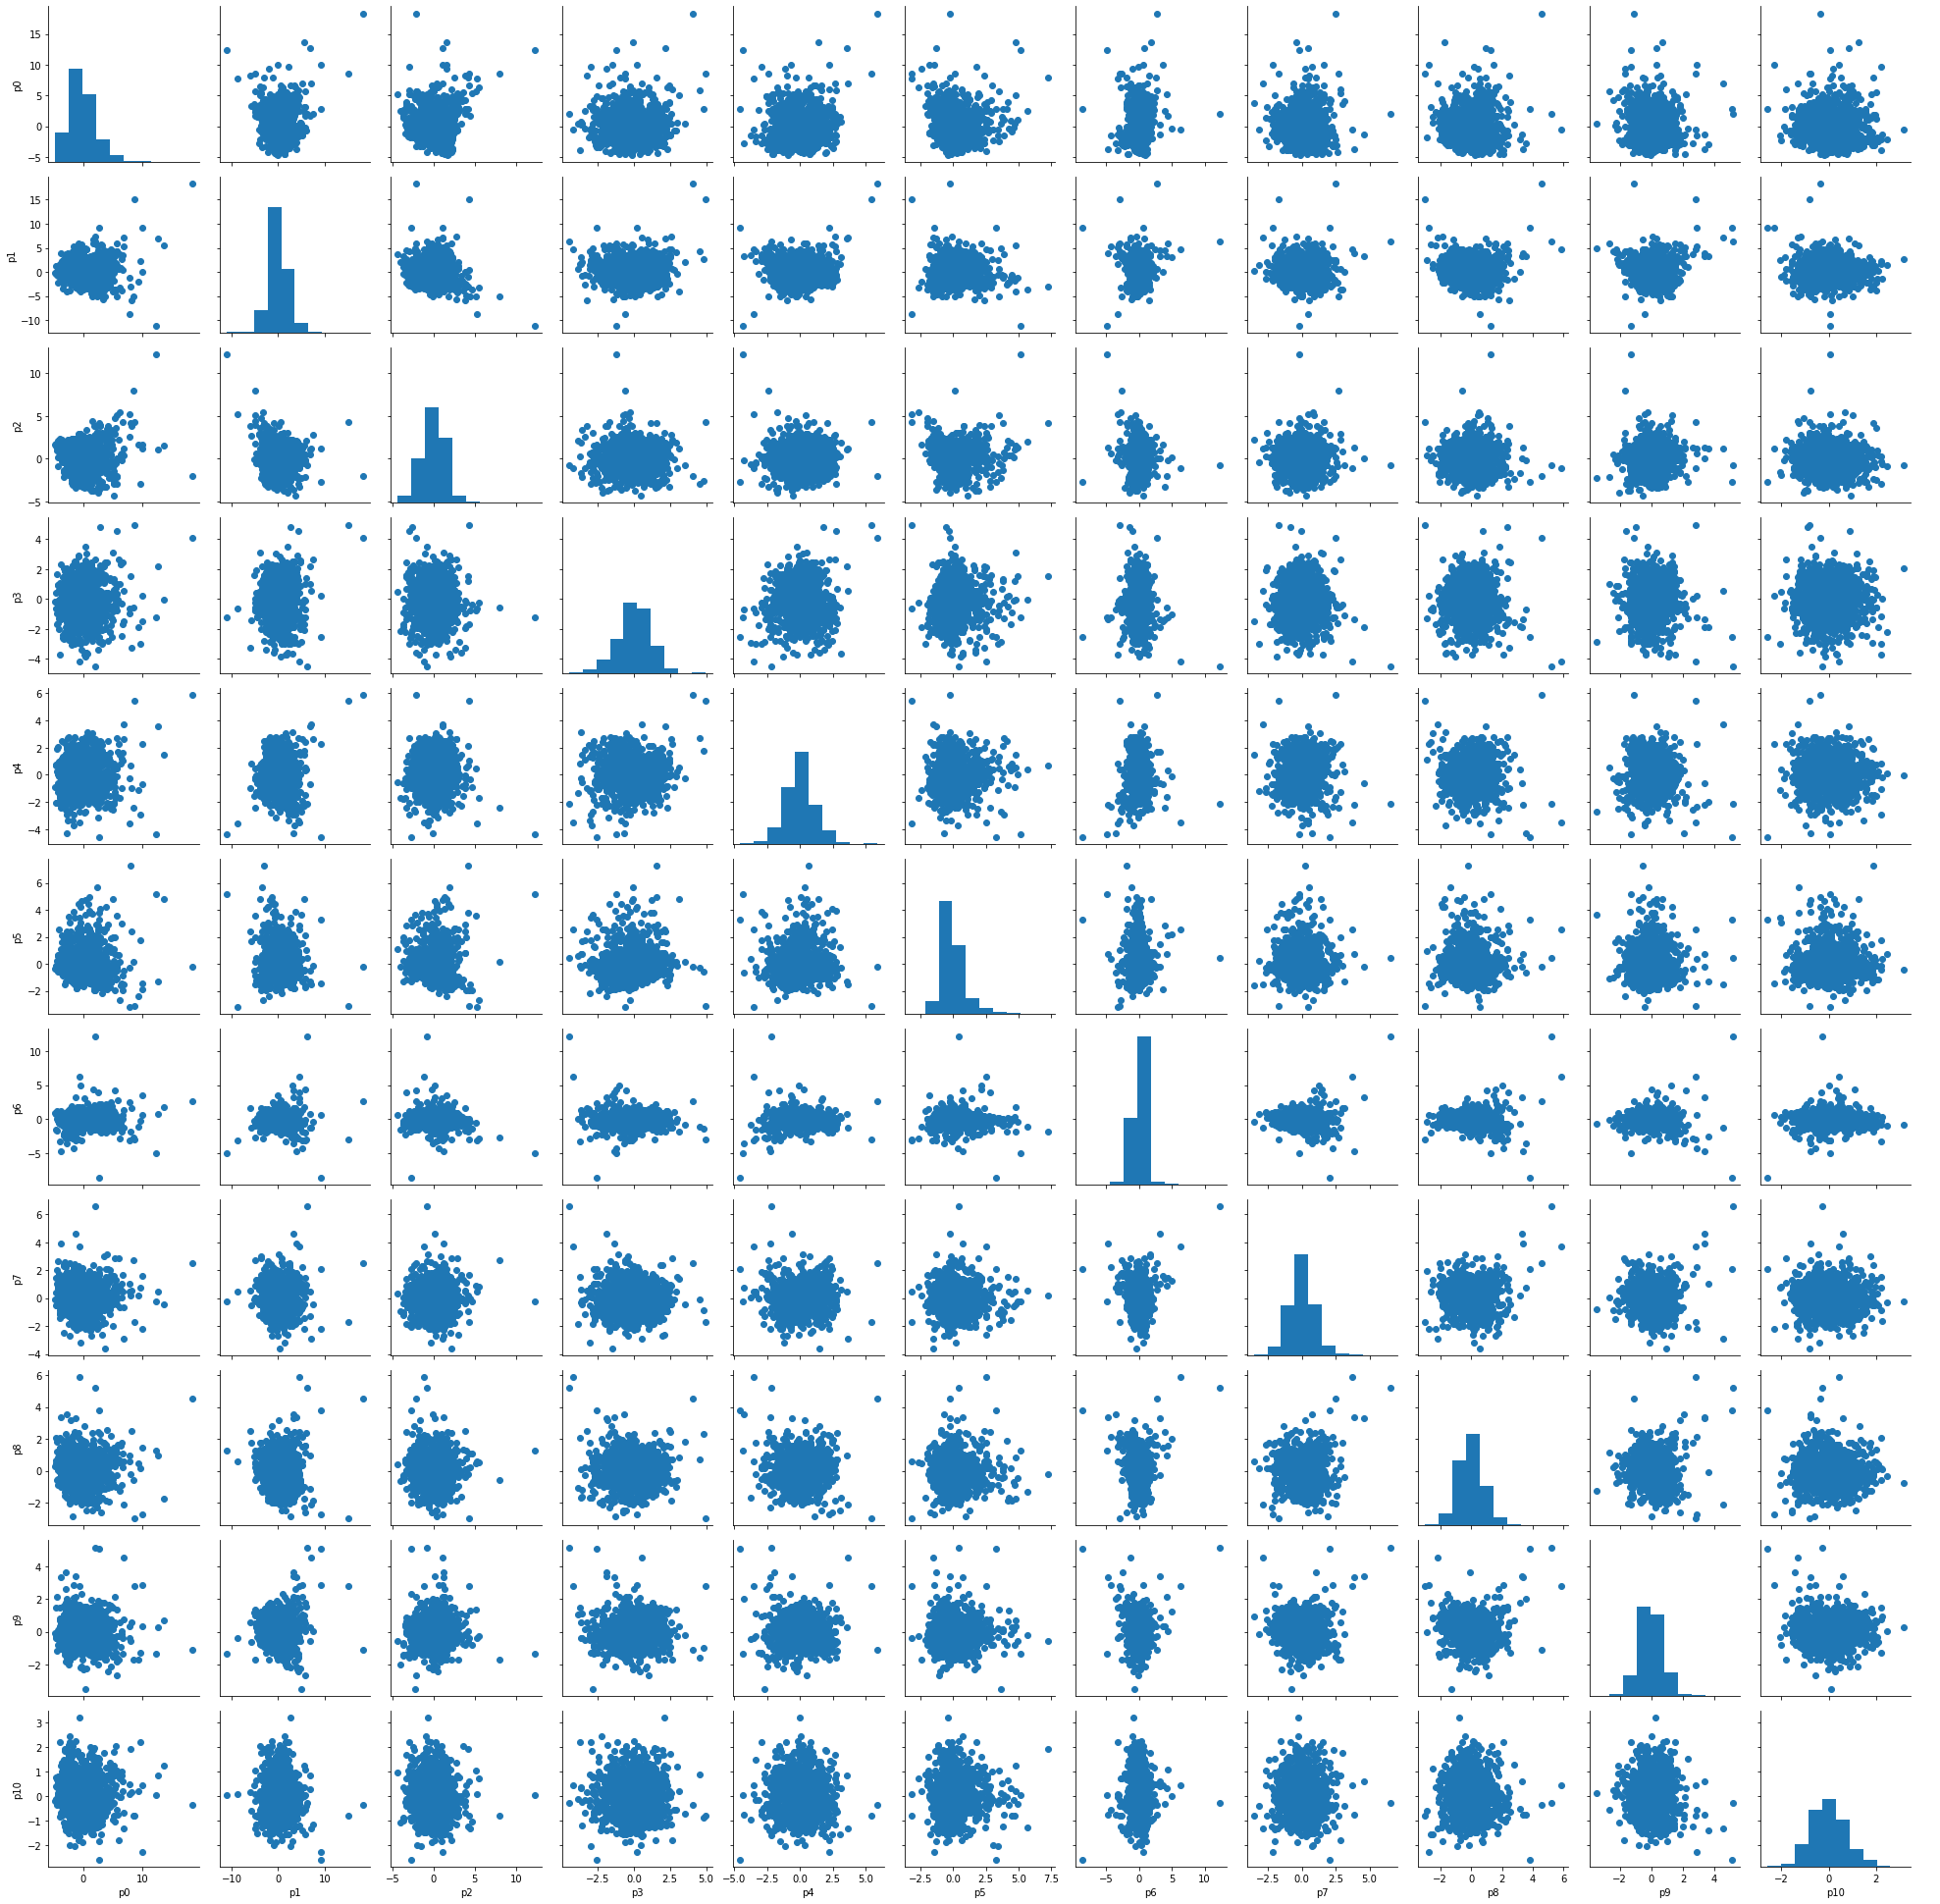

In [8]:
g = sns.PairGrid(Xp)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

In [9]:
# Varianza explicada
pca.explained_variance_ratio_.cumsum()

array([0.25624807, 0.4641155 , 0.56385639, 0.62796657, 0.68547635,
       0.73420699, 0.77638379, 0.81589832, 0.8522532 , 0.88204568,
       0.90706069])

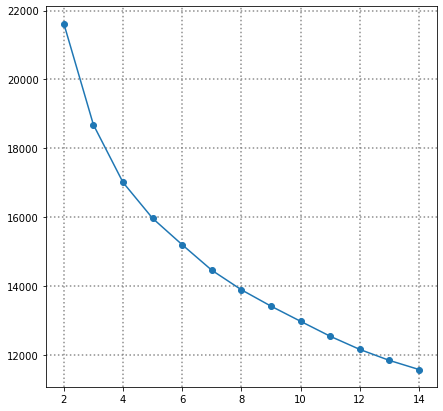

In [10]:
# Número de Clústers, por regla del codo:
from sklearn.cluster import KMeans

inertias_ = []
for i in range(2,15):
    kmeans = KMeans(i)
    kmeans.fit(Xp)
    inertias_.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(range(2,15), inertias_, marker='o')
ax.grid(b=True, which='major', color='gray', alpha=.9, linestyle='dotted', lw=1.5)

In [11]:
k = 5

In [12]:
Xp_aux = Xp.copy()

In [13]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture


In [14]:
ward = AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage='ward')
ward = ward.fit(Xp)
Xp_aux['cl_ward'] = ward.fit_predict(Xp)

In [15]:
kmeans = KMeans(k)
kmeans = kmeans.fit(Xp)
Xp_aux['cl_kmeans'] = kmeans.fit_predict(Xp)

In [16]:
gaussian = GaussianMixture(k)
gaussian = gaussian.fit(Xp)
Xp_aux['cl_gaussian'] = gaussian.fit_predict(Xp)

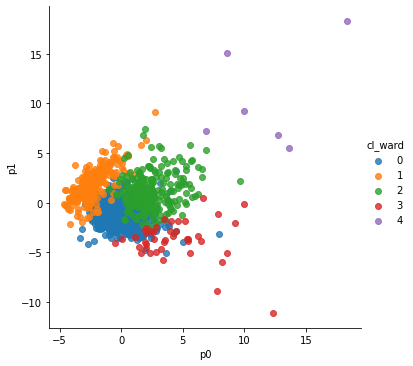

In [17]:
# WARD
var_ = 'cl_ward'
sns.lmplot(data=Xp_aux, x='p0', y='p1', fit_reg=False, hue=var_)

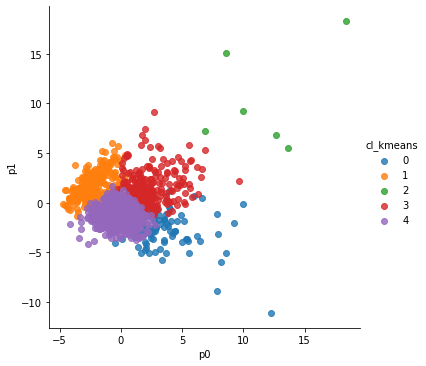

In [18]:
# K Means
var_ = 'cl_kmeans'
sns.lmplot(data=Xp_aux, x='p0', y='p1', fit_reg=False, hue=var_)

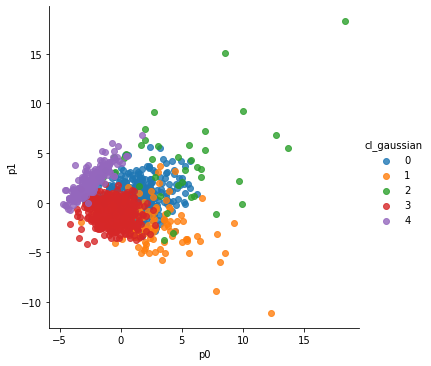

In [19]:
# Gaussian
var_ = 'cl_gaussian'
sns.lmplot(data=Xp_aux, x='p0', y='p1', fit_reg=False, hue=var_)

# Escogemos KMeans :)

In [20]:
res = df_p.copy()

In [21]:
res['cl'] = Xp_aux['cl_kmeans']
res.head(5)

,Person,CurrentAge,FICOScore,RetirementAge,YearlyIncome_Person,TotalDebt,NumCreditCards,TotalAmount,AvgAmount,MaxAmount,...,AbroadTrans,AvgUSAmount,AvgOnlineAmount,AvgAbroadAmount,MaxCreditLimit,MinCreditLimit,AvgCreditLimit,Antiquity,RemainingYears,cl
0,Aaden Campbell,33,763,69,59613.0,36199.0,4,629403.44,74.22,1128.47,...,146,63.25,9.28,1.69,17600.0,17600.0,17600.00,14.0,36.0,3
1,Aaliyah Martin,43,704,74,45360.0,14587.0,3,581856.99,40.01,937.15,...,54,30.59,9.08,0.34,12800.0,10900.0,11793.04,18.0,31.0,0
2,Aarav Farhad,48,673,64,27447.0,80850.0,5,284571.90,41.46,534.84,...,0,36.42,5.04,0.00,7800.0,7400.0,7513.65,15.0,16.0,4
3,Abby Wood,54,716,72,76431.0,115362.0,5,190148.65,68.74,1624.15,...,93,58.66,8.70,1.39,19300.0,19300.0,19300.00,11.0,18.0,3
4,Abigail Morales,19,782,63,55854.0,111042.0,1,4488.90,61.49,352.14,...,0,58.39,3.10,0.00,14600.0,14600.0,14600.00,0.0,44.0,1


# Perfilamiento de grupos

In [22]:
res['cl'].value_counts(1)

4    0.483025
1    0.246142
3    0.187500
0    0.078704
2    0.004630
Name: cl, dtype: float64

In [23]:
res['cl'].value_counts()

4    626
1    319
3    243
0    102
2      6
Name: cl, dtype: int64

In [24]:
res.groupby('cl').agg('mean')

,CurrentAge,FICOScore,RetirementAge,YearlyIncome_Person,TotalDebt,NumCreditCards,TotalAmount,AvgAmount,MaxAmount,MinAmount,...,OnlineTrans,AbroadTrans,AvgUSAmount,AvgOnlineAmount,AvgAbroadAmount,MaxCreditLimit,MinCreditLimit,AvgCreditLimit,Antiquity,RemainingYears
cl,,,,,,,,,,,,,,,,,,,,,
0,54.343137,704.196078,66.911765,48303.686275,63392.843137,3.441176,1.243884e+06,61.435784,1628.328137,0.383431,...,2826.715686,140.656863,53.098431,7.742353,0.595686,14132.352941,10818.627451,13046.991961,17.352941,15.460784
1,26.915361,712.821317,66.285266,44546.231975,72262.611285,2.542320,4.263694e+04,62.131599,542.861724,2.623793,...,78.968652,3.924765,53.329592,8.558558,0.243292,10959.561129,9865.517241,10317.019436,1.652038,39.369906
2,53.500000,709.166667,67.166667,235600.500000,310040.166667,4.000000,7.911479e+05,133.968333,3806.700000,1.115000,...,1286.333333,153.000000,107.778333,21.881667,4.305000,64633.333333,45766.666667,59067.610000,11.166667,13.666667
3,50.156379,724.991770,66.781893,67227.934156,82691.436214,4.008230,5.373940e+05,95.454444,1742.255144,0.935432,...,602.975309,71.300412,80.387078,13.544239,1.523128,19235.802469,15936.625514,17971.947407,12.078189,18.024691
4,55.891374,718.279553,66.523962,35037.095847,45247.928115,3.873802,3.455208e+05,59.278147,1115.011262,0.523067,...,578.912141,24.626198,51.171486,7.687348,0.419505,9810.223642,7847.124601,8972.024217,13.303514,13.313099


In [56]:
#res.groupby('cl').agg('mean').to_csv("/Users/karla/Documents/Docs/Credit Cards Transactions/Results.csv")

## Prueba de Kruskall Wallis

In [25]:
from scipy import stats

def kruskal_wallis_test(df:pd.DataFrame, columns:list, part_col:str):
    
    '''La función se encarga de tomar las columnas que sean indicadas de un mismo dataframe y comparar las poblaciones
        basada en una partición dada la columna objetivo.
        df: el dataframe de pandas con las columnas.
        columns: columnas sobre las que se ejecutará la prueba.
        part_col: columna sobre la cuál se crearán las diferentes poblaciones.'''
    
    values_ = list(df[part_col].unique())
    results_ = dict()
    
    frames_ = dict(zip(values_, [df.loc[df[part_col]==v] for v in values_]))
    
    for c in columns:
        populations = [frames_.get(v)[c].values for v in values_]
        results_[c] = stats.kruskal(*populations)

    return(results_)

In [28]:
varc=X

In [29]:
kruskal_wallis_test(res.loc[res['cl'].isin([0, 2])], varc, 'cl')

{'CurrentAge': KruskalResult(statistic=0.4324622321277834, pvalue=0.5107832351844801),
 'FICOScore': KruskalResult(statistic=0.0432249993484822, pvalue=0.8353021867385574),
 'RetirementAge': KruskalResult(statistic=0.14874158618673428, pvalue=0.6997408557918094),
 'YearlyIncome_Person': KruskalResult(statistic=16.84403669724776, pvalue=4.0580636591490325e-05),
 'TotalDebt': KruskalResult(statistic=13.407163172037759, pvalue=0.00025066521887856606),
 'NumCreditCards': KruskalResult(statistic=1.0313816087682464, pvalue=0.3098343882924863),
 'TotalAmount': KruskalResult(statistic=2.67745997481569, pvalue=0.10177794848204547),
 'AvgAmount': KruskalResult(statistic=16.29815282803118, pvalue=5.411667890762404e-05),
 'MaxAmount': KruskalResult(statistic=6.024284943335147, pvalue=0.014110347194954204),
 'MinAmount': KruskalResult(statistic=9.830586407583036, pvalue=0.0017163362145528934),
 'TotalTransactions': KruskalResult(statistic=15.654794027702906, pvalue=7.60196310707759e-05),
 'USTrans'

In [37]:
# Las variables que mejor segmentan con la prueba de kruskall-wallis:
# Hipotesis nula:  Todas las muestras provienen de la misma población
# Hipotesis alternativa: Al menos una muestra proviene de una población con una distribución distinta.

var_segk=['TotalDebt', 'MaxAmount', 'MinAmount','AvgAmount',
        'TotalTransactions','USTrans','OnlineTrans',
        'AvgUSAmount', 'AvgOnlineAmount', 'AvgAbroadAmount',
         'MaxCreditLimit', 'MinCreditLimit', 'AvgCreditLimit',
         'Antiquity']

In [38]:
len(var_segk)

14

## Prueba de Tuckey

In [30]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
def tukeyhsd(df:pd.DataFrame, columns:list, part_col:str, alpha=.05):
    
    results_ = dict()
    
    for c in columns:
        print(f'Starting with... {c}')
        tukey = pairwise_tukeyhsd(endog=df[c], groups=df[part_col], alpha=alpha)
        print(tukey)
        results_[c] = tukey
        print(f'{c} finished... \n')

    return(results_)

In [32]:
tukeyhsd(res.loc[res['cl'].isin([0,1,2,3,4])], varc, 'cl')

Starting with... CurrentAge
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1 -27.4278  0.001 -31.7163 -23.1393   True
     0      2  -0.8431    0.9 -16.6809  14.9946  False
     0      3  -4.1868 0.0765  -8.6347   0.2612  False
     0      4   1.5482 0.8091  -2.4774   5.5739  False
     1      2  26.5846  0.001   11.049  42.1202   True
     1      3   23.241  0.001  20.0309  26.4512   True
     1      4   28.976  0.001  26.3825  31.5695   True
     2      3  -3.3436    0.9  -18.924  12.2368  False
     2      4   2.3914    0.9 -13.0737  17.8565  False
     3      4    5.735  0.001   2.8854   8.5845   True
------------------------------------------------------
CurrentAge finished... 

Starting with... FICOScore
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
------------------------------------------

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj    lower       upper    reject
--------------------------------------------------------------
     0      1  -2729.9725 0.001  -4216.6384  -1243.3066   True
     0      2   46020.618 0.001  40530.2189  51511.0172   True
     0      3   4924.9554 0.001    3382.992   6466.9189   True
     0      4  -4074.9677 0.001  -5470.5203  -2679.4152   True
     1      2  48750.5906 0.001  43364.9363  54136.2448   True
     1      3    7654.928 0.001   6542.0759     8767.78   True
     1      4  -1344.9952 0.001   -2244.081   -445.9094   True
     2      3 -41095.6626 0.001 -46496.8428 -35694.4824   True
     2      4 -50095.5858 0.001 -55456.8042 -44734.3674   True
     3      4  -8999.9232 0.001  -9987.7649  -8012.0815   True
--------------------------------------------------------------
AvgCreditLimit finished... 

Starting with... Antiquity
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 

{'CurrentAge': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7f9ff0189940>,
 'FICOScore': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa0251b8e50>,
 'RetirementAge': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa0251cd970>,
 'YearlyIncome_Person': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040b93460>,
 'TotalDebt': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040b9f340>,
 'NumCreditCards': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040b9f3d0>,
 'TotalAmount': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040bb1e50>,
 'AvgAmount': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040bbcf40>,
 'MaxAmount': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040bc8e80>,
 'MinAmount': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040c8cd30>,
 'TotalTransactions': <statsmodels.sandbox.stats.multicomp.TukeyHSDResults at 0x7fa040c98c10>,
 'USTrans': <

In [33]:
# Las variables que mejor segmentan con la prueba de Tukey son:
var_segT=['YearlyIncome_Person', 'TotalDebt','TotalAmount',
         'MaxAmount', 'TotalTransactions', 'USTrans', 'OnlineTrans',
         'AbroadTrans', 'AvgUSAmount', 'AvgOnlineAmount', 'MaxCreditLimit',
         'MinCreditLimit','AvgCreditLimit', 'Antiquity']

In [41]:
perfil=res[var_segT+['cl']]

In [42]:
perfil.groupby('cl').agg('mean')

,YearlyIncome_Person,TotalDebt,TotalAmount,MaxAmount,TotalTransactions,USTrans,OnlineTrans,AbroadTrans,AvgUSAmount,AvgOnlineAmount,MaxCreditLimit,MinCreditLimit,AvgCreditLimit,Antiquity
cl,,,,,,,,,,,,,,
0,48303.686275,63392.843137,1.243884e+06,1628.328137,20419.803922,17452.431373,2826.715686,140.656863,53.098431,7.742353,14132.352941,10818.627451,13046.991961,17.352941
1,44546.231975,72262.611285,4.263694e+04,542.861724,734.347962,651.454545,78.968652,3.924765,53.329592,8.558558,10959.561129,9865.517241,10317.019436,1.652038
2,235600.500000,310040.166667,7.911479e+05,3806.700000,6402.166667,4962.833333,1286.333333,153.000000,107.778333,21.881667,64633.333333,45766.666667,59067.610000,11.166667
3,67227.934156,82691.436214,5.373940e+05,1742.255144,5833.650206,5159.374486,602.975309,71.300412,80.387078,13.544239,19235.802469,15936.625514,17971.947407,12.078189
4,35037.095847,45247.928115,3.455208e+05,1115.011262,6041.589457,5438.051118,578.912141,24.626198,51.171486,7.687348,9810.223642,7847.124601,8972.024217,13.303514
